In [41]:
import pandas as pd
from sklearn import metrics,model_selection

In [42]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [43]:
df = pd.read_parquet('../../data/sample_data.parquet').dropna(subset='rubm2')
df = df.drop(['datetime','publish_delta','url','id','text','Город','title','img_list','metro_branch','metro_name','metro_dist'],axis=1)

In [44]:
df['rubm2'].median()

290000.0

In [45]:
df['rooms'] = df['rooms'].where(lambda x: x.isin(df['rooms'].value_counts().iloc[:6].index),'Other')

In [46]:
df.groupby('rooms')['rubm2'].median()

rooms
1-комн. апарт.    308333.333333
1-комн. кв.       291428.571429
2-комн. апарт.    347406.914894
2-комн. кв.       284482.758621
3-комн. апарт.    476312.525837
3-комн. кв.       284854.070661
Other             338095.238095
Name: rubm2, dtype: float64

In [47]:
df['price'].isna().mean()

0.0

In [48]:
_metrics = {}

# baseline v0

In [49]:
v0 = metrics.mean_absolute_percentage_error(df['rubm2'],[df['rubm2'].median()]*df.shape[0])
_metrics.update(
    {'baseline':v0}
)

# baseline v0.1

In [50]:
base_data = df.copy()

In [51]:
base_data['is_apart'] = base_data['rooms'].str.contains('апарт')

In [52]:
base_data['n_rooms'] = base_data['rooms'].str.extract('(\d)').fillna(0).astype(float)

In [53]:
target = base_data['rubm2']
data = base_data.select_dtypes(exclude='O').drop(['lat','long','price','rubm2'],axis=1)
# data['rub_m2'] = base_data.groupby(['n_rooms','max_floor','is_apart'])['rubm2'].transform('mean')
data = data.fillna(data.median())

In [54]:
x,xv,y,yv = model_selection.train_test_split(data,target,train_size=.75)

In [55]:
from catboost import CatBoostRegressor

In [56]:
model = CatBoostRegressor(2000)

In [57]:
model.fit(x,y,verbose=500)

Learning rate set to 0.028677
0:	learn: 176707.4609415	total: 2.25ms	remaining: 4.49s
500:	learn: 77695.5652299	total: 503ms	remaining: 1.51s
1000:	learn: 65588.6218255	total: 1.07s	remaining: 1.06s
1500:	learn: 58421.0821871	total: 1.57s	remaining: 523ms
1999:	learn: 53143.8168063	total: 2.07s	remaining: 0us


In [58]:
_metrics.update(
   {'base_model': metrics.mean_absolute_percentage_error(yv,model.predict(xv))}
)

# v1

In [59]:
v1_data = df.copy()

In [60]:
v1_data['advanced_home_info'].apply(lambda x: pd.DataFrame(x).set_index('key')['value'].to_dict())

0       {'Год_ввода_в_эксплуатацию': '2004', 'Дом_приз...
1       {'Год_ввода_в_эксплуатацию': '2022', 'Дом_приз...
2       {'Год_ввода_в_эксплуатацию': '2014', 'Дом_приз...
3       {'Год_ввода_в_эксплуатацию': '2017', 'Дом_приз...
4       {'Год_ввода_в_эксплуатацию': '1973', 'Дом_приз...
                              ...                        
5233    {'Год_ввода_в_эксплуатацию': '1968', 'Дом_приз...
5234    {'Год_ввода_в_эксплуатацию': '1963', 'Дом_приз...
5235    {'Год_ввода_в_эксплуатацию': '2022', 'Дом_приз...
5236    {'Год_ввода_в_эксплуатацию': '1984', 'Дом_приз...
5237    {'Год_ввода_в_эксплуатацию': '1977', 'Дом_приз...
Name: advanced_home_info, Length: 4957, dtype: object

In [61]:
v1_data['advanced_home_dict'] = v1_data['advanced_home_info'].apply(lambda x: pd.DataFrame(x).set_index('key')['value'].to_dict())
v1_data['year_of_build'] = v1_data['advanced_home_dict'].apply(lambda x: x.get('Год_ввода_в_эксплуатацию'))
v1_data['rent_counts'] = v1_data['advanced_home_dict'].apply(lambda x: x.get('Количество_квартир'))
v1_data['n_enterss'] = v1_data['advanced_home_dict'].apply(lambda x: x.get('Количество_подъездов'))
v1_data['m2_house'] = v1_data['advanced_home_dict'].apply(lambda x: x.get('Площадь_многоквартирного_дома,_кв.м'))
v1_data['n_rooms'] = v1_data['rooms'].str.extract('(\d)').fillna(0).astype(float)
v1_data['is_apart'] = v1_data['rooms'].str.contains('апарт')


In [62]:
v1_data['area_obj_cnt'] = v1_data.groupby('Округ')['rubm2'].transform('count')
v1_data['metro_obj_cnt'] = v1_data.groupby('Метро')['rubm2'].transform('count')
v1_data['district_obj_cnt'] = v1_data.groupby('Район')['rubm2'].transform('count')


In [63]:
v1_data['Округ'] = v1_data.groupby('Округ')['rubm2'].transform('mean')
v1_data['Метро'] = v1_data.groupby('Метро')['rubm2'].transform('mean')
v1_data['Район'] = v1_data.groupby('Район')['rubm2'].transform('mean')
v1_data['postcode'] = v1_data['postcode'].explode().astype(float).groupby(level=0).mean() // 100

In [64]:
import numpy as np

In [65]:
data = v1_data.select_dtypes(exclude='O').drop(['price','rubm2'],axis=1).pipe(lambda x: x.fillna(x.mean()))
target = v1_data['rubm2']
target_clipped = v1_data['rubm2'].clip(0,v1_data['rubm2'].quantile(.95))

In [66]:
data_filtred = v1_data.query('price < price.quantile(.9)').select_dtypes(exclude='O').drop(['price','rubm2'],axis=1).pipe(lambda x: x.fillna(x.mean()))
target_filtred = v1_data.query('price < price.quantile(.9)')['rubm2']

In [67]:
x,xv,y,yv = model_selection.train_test_split(data_filtred,target_filtred,train_size=.75)

In [68]:
model_v1 = CatBoostRegressor(5000)

In [69]:
model_v1.fit(x,y,verbose=500)

Learning rate set to 0.01339
0:	learn: 89007.2331623	total: 3.49ms	remaining: 17.4s
500:	learn: 46377.7072199	total: 527ms	remaining: 4.74s
1000:	learn: 41684.5436615	total: 1.13s	remaining: 4.51s
1500:	learn: 38392.0938308	total: 1.8s	remaining: 4.2s
2000:	learn: 35404.8897223	total: 2.33s	remaining: 3.49s
2500:	learn: 32932.5178080	total: 2.96s	remaining: 2.96s
3000:	learn: 30827.4857104	total: 3.53s	remaining: 2.35s
3500:	learn: 28962.9142799	total: 4.07s	remaining: 1.74s
4000:	learn: 27363.7854397	total: 4.63s	remaining: 1.16s
4500:	learn: 25979.0220209	total: 5.18s	remaining: 574ms
4999:	learn: 24712.6510132	total: 5.74s	remaining: 0us


In [70]:
_metrics.update(
   {'model_v1': metrics.mean_absolute_percentage_error(yv,model_v1.predict(xv))}
)

In [71]:
from sklearn import linear_model,pipeline,preprocessing

model_v2 = pipeline.Pipeline(
    [
        ('scaler',preprocessing.StandardScaler()),
        ('model',linear_model.HuberRegressor()),
     ]
)

In [72]:
def get_meta_features(data):
    data = df.copy()
    data['area_obj_cnt'] = data.groupby('Округ')['rubm2'].transform('count')
    data['metro_obj_cnt'] = data.groupby('Метро')['rubm2'].transform('count')
    data['district_obj_cnt'] = data.groupby('Район')['rubm2'].transform('count')
    data['Округ'] = data.groupby('Округ')['rubm2'].transform('mean')
    data['Метро'] = data.groupby('Метро')['rubm2'].transform('mean')
    data['Район'] = data.groupby('Район')['rubm2'].transform('mean')

    return data[['area_obj_cnt','metro_obj_cnt','district_obj_cnt','Округ','Метро','Район']]



In [73]:
def dataset_prepare(df):
    data = df.copy()
    data['advanced_home_dict'] = data['advanced_home_info'].apply(lambda x: pd.DataFrame(x).set_index('key')['value'].to_dict())
    data['year_of_build'] = data['advanced_home_dict'].apply(lambda x: x.get('Год_ввода_в_эксплуатацию'))
    data['rent_counts'] = data['advanced_home_dict'].apply(lambda x: x.get('Количество_квартир'))
    data['n_enterss'] = data['advanced_home_dict'].apply(lambda x: x.get('Количество_подъездов'))
    data['m2_house'] = data['advanced_home_dict'].apply(lambda x: x.get('Площадь_многоквартирного_дома,_кв.м'))

    data['n_rooms'] = data['rooms'].str.extract('(\d)').fillna(0).astype(float)
    data['is_apart'] = data['rooms'].str.contains('апарт')
    data['postcode'] = data['postcode'].explode().astype(float).groupby(level=0).mean() // 100
    

    # meta_data = get_meta_features(data)
    # result = .join(meta_data)

    return data.drop(['Округ','Метро','Район'],axis=1)



In [74]:
model_v2.fit(x,y.clip(0,y.quantile(.95)))

Pipeline(steps=[('scaler', StandardScaler()), ('model', HuberRegressor())])

In [75]:
metrics.mean_absolute_percentage_error(yv,model_v2.predict(xv))

0.12487289968059563

In [76]:
_metrics.update(
   {'model_v2_poisson': metrics.mean_absolute_percentage_error(yv,model_v2.predict(xv))}
)

# Result

In [77]:
target.to_frame()\
    .assign(
    predict_cat = model_v1.predict(data),
    predict_poiss = model_v2.predict(data),
    ).apply(lambda x: (x['rubm2'] / x )-1,axis=1).abs().mean()

rubm2            0.000000
predict_cat      0.145731
predict_poiss    0.164666
dtype: float64

In [78]:
target.to_frame()\
    .assign(
    predict_cat = model_v1.predict(data),
    predict_poiss = model_v2.predict(data),
    ).apply(lambda x: (x['rubm2'] / x )-1,axis=1).abs()\
        .loc[target.where(lambda x: x < x.quantile(.9)).dropna().index].mean()

rubm2            0.000000
predict_cat      0.073096
predict_poiss    0.121753
dtype: float64

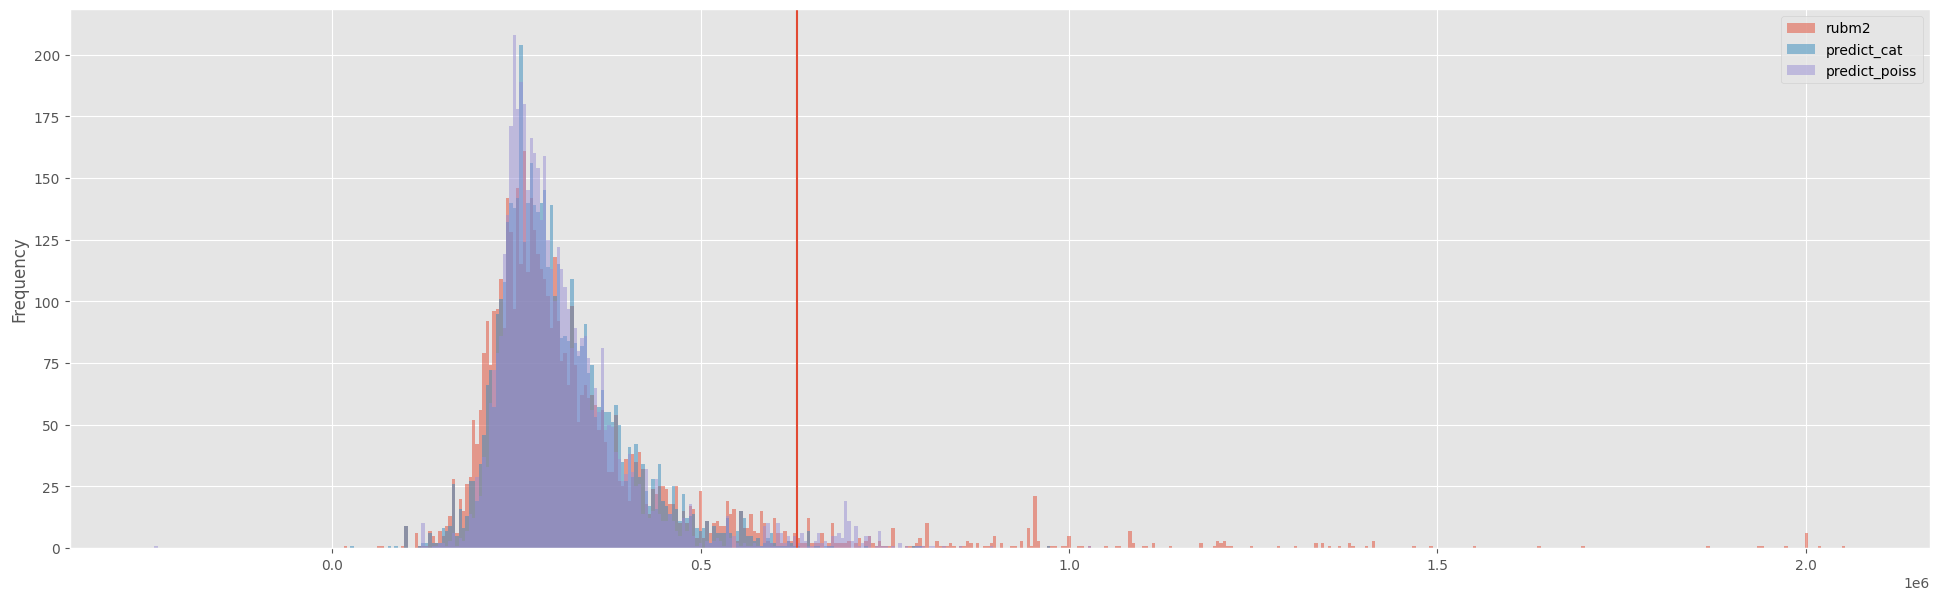

In [79]:
target.to_frame()\
    .assign(
    predict_cat = model_v1.predict(data),
    predict_poiss = model_v2.predict(data),
    ).plot.hist(bins=500,alpha=0.5,figsize=(24,7))
plt.axvline(target.quantile(.95))

In [80]:
_metrics

{'baseline': 0.25244297885044187,
 'base_model': 0.17070396181204736,
 'model_v1': 0.09844420978301706,
 'model_v2_poisson': 0.12487289968059563}